# Imports

In [4]:
from __future__ import annotations

#import essential functions
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import pygame
import time
import random

import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
#for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '2.0'  # set timeout to 2 seconds

# Useful classes and functions

In [2]:
from sklearn.linear_model import LogisticRegression

#define epsilon-greedy policy
def epsilon_greedy(QF, state, num_actions, epsilon):
    if np.random.uniform() < epsilon:
        # Choose a random action with probability epsilon
        return np.random.choice(num_actions)
    else:
        # Choose the action with highest Q-value for the current state
        #check if QF is a torch neural network, if so retrun the index of the max value given the state
        if isinstance(QF, torch.nn.modules.module.Module):
            return torch.argmax(QF(torch.tensor(state).float().to(device))).item()
        #else if QF is a sklearn logistic regression model, if so retrun the index of the max value given the state
        elif isinstance(QF, LogisticRegression):
            return np.argmax(QF.predict_proba([state]))
        else:
            #else return the index of the max value given the state in QF table
            return np.argmax(QF[state, :])

#define uniform random policy
def uniform_random(num_actions):
    return np.random.choice(num_actions)

#define softmax boltzmann policy
def softmax_boltzmann(Q, state, num_actions, temperature):
    # Calculate the probabilities using the softmax function
    probs = softmax(Q[state, :] / temperature)
    # Choose an action using the calculated probabilities
    return np.random.choice(num_actions, p=probs)

# Define the softmax function prevent overflow
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


## Space invaders environment

### Normal env random agent template (non-parralel, runs slower, incomplete)

In [ ]:
env = space_invaders_v2.env(render_mode="human", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
#env = space_invaders_v2.env(render_mode="human", alternating_control=True, moving_shields=False, zigzaging_bombs=True, fast_bomb=True, invisible_invaders=True)
#env = space_invaders_v2.env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)
env.reset(seed=seed)

clock = pygame.time.Clock()

for agent in env.agent_iter():
    clock.tick(env.metadata["render_fps"]) #used to limit the fps in render mode human

    observation, reward, termination, truncation, info = env.last()
    action = env.action_space(agent).sample() #define policy or uniform_random(env.action_space(agent).n
    #break the loop if the game is over
    if termination or truncation:
        print("Game Over")
        break

    #check conditions for each reward
    #if reward is between 0 and 200 then the agent has killed an invader
    if reward > 0 and reward < 200:
        print("Agent {} has killed an invader".format(agent))
        if reward == 100:
            print("Agent {} has killed a flying saucer".format(agent))
    elif reward == 200:
        print("Agent {} has betrayed the other agent".format(agent))

    env.step(action)
    
    env.render()

#env.close() #not closing to see the final result

### Parallel env random agent template (runs faster)

In [10]:
#parallel env initialization
parallel_env = space_invaders_v2.parallel_env(render_mode="human")

#hyperparameters
gamma = 0.999 #discount factor
episode_count = 2


#array to store the total episode rewards for each agent
ep_rewards = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
#array to store the total discounted episode rewards for each agent
ep_rewards_d = {agent: np.zeros(episode_count) for agent in parallel_env.possible_agents}
#array to store the total episode steps for all agents
ep_steps = np.zeros(episode_count)
#array to store the total discounted episode steps for all agents
ep_steps_d = np.zeros(episode_count)
#array to store the total episode reward for all agents
ep_rewards_all = np.zeros(episode_count)
#array to store the total discounted episode reward for all agents
ep_rewards_d_all = np.zeros(episode_count)


for ep in tqdm(range(episode_count)):
    agent_states = parallel_env.reset()
    first_0_state, second_0_state = agent_states['first_0'], agent_states['second_0']
    assert np.array_equal(first_0_state, second_0_state) #check if the states are the same for both agents (they should be)

    terminations = {agent: False for agent in parallel_env.possible_agents}
    truncations = {agent: False for agent in parallel_env.possible_agents}

    clock = pygame.time.Clock()
    #run while loop until the game is over for all terminations and truncations are true for all agents in the parallel env
    while not all(terminations.values()) and not all(truncations.values()):
        clock.tick(parallel_env.metadata["render_fps"]) #used to limit the fps in render mode human

        #sample random actions for each agent or TODO define policy
        actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.possible_agents}
        agent_states, rewards, terminations, truncations, infos = parallel_env.step(actions)
        
        assert np.array_equal(agent_states['first_0'], agent_states['second_0']) #check if the states are the same for both agents (they should be)
        
        #print("Episode: {}".format(ep))
        #print("Agent actions: {}".format(actions))
        #print("Agent states: {}".format(agent_states))
        #print("Rewards: {}".format(rewards))
        #print("Terminations: {}".format(terminations))
        #print(truncations)
        #print(infos)
        #print("steps: {}".format(ep_steps[ep]))

        #check conditions for each reward for each agent and store the acuumulated rewards in the arrays defined above
        #if reward is between 0 and 200 then the agent has killed an invader, if reward is 100 then the agent has killed a flying saucer, if reward is 200 then the agent has betrayed the other agent, if reward is 0 then the agent has not killed anything
        for agent in parallel_env.possible_agents:
            if rewards[agent] > 0 and rewards[agent] < 200:
                print("Agent {} has killed an invader".format(agent))
                if rewards[agent] == 100:
                    print("Agent {} has killed a flying saucer".format(agent))
            elif rewards[agent] == 200:
                print("Agent {} has betrayed the other agent".format(agent))

            ep_rewards[agent][ep] += rewards[agent]
            ep_rewards_d[agent][ep] += rewards[agent] * (gamma ** ep_steps[ep])

        ep_rewards_d_all[ep] += sum(rewards.values()) * (gamma ** ep_steps[ep])

        #store the number of steps in each episode
        ep_steps[ep] += 1

        #stores intrinsic motivation, based on agent's total survival time or iteration (they can both die at the same time and get 200 reward together)
        ep_steps_d[ep] += 1 * (gamma ** ep_steps[ep])
        

        parallel_env.render()
    
    #print the above rewards for this episode
    print("Episode {} total rewards: {}".format(ep, ep_rewards))
    print("Episode {} total discounted rewards: {}".format(ep, ep_rewards_d))
    print("Episode {} total discounted rewards for all agents: {}".format(ep, ep_rewards_d_all))

    #print the total steps for this episode
    print("Episode {} total steps: {}".format(ep, ep_steps[ep]))

#parallel_env.close() #not closing to see the final result



  0%|          | 0/2 [00:00<?, ?it/s]

Agent first_0 has killed an invader
Agent first_0 has killed an invader
Agent first_0 has betrayed the other agent
Agent second_0 has killed an invader
Agent first_0 has killed an invader
Agent first_0 has killed an invader
Agent second_0 has killed an invader
Agent second_0 has betrayed the other agent
Agent second_0 has killed an invader
Agent second_0 has killed an invader
Agent first_0 has killed an invader
Agent first_0 has killed an invader
Agent first_0 has betrayed the other agent
Agent second_0 has killed an invader


 50%|█████     | 1/2 [00:18<00:18, 18.64s/it]

Episode 0 total rewards: {'first_0': array([465.,   0.]), 'second_0': array([275.,   0.])}
Episode 0 total discounted rewards: {'first_0': array([235.79591052,   0.        ]), 'second_0': array([129.63295029,   0.        ])}
Episode 0 total discounted rewards for all agents: [365.42886081   0.        ]
Episode 0 total steps: 1150.0
Agent second_0 has betrayed the other agent
Agent second_0 has killed an invader
Agent second_0 has killed an invader
Agent first_0 has betrayed the other agent
Agent second_0 has killed an invader
Agent second_0 has killed an invader
Agent second_0 has killed an invader
Agent first_0 has killed an invader
Agent second_0 has killed an invader
Agent second_0 has killed an invader
Agent first_0 has betrayed the other agent


100%|██████████| 2/2 [00:44<00:00, 22.09s/it]

Episode 1 total rewards: {'first_0': array([465., 430.]), 'second_0': array([275., 310.])}
Episode 1 total discounted rewards: {'first_0': array([235.79591052, 136.25172868]), 'second_0': array([129.63295029, 192.22471835])}
Episode 1 total discounted rewards for all agents: [365.42886081 328.47644703]
Episode 1 total steps: 1578.0


In [9]:
print(dir(parallel_env))
#print all 'possible_agents', 'render', 'reset', 'seed', 'state', 'step', 'unwrapped'
print(parallel_env.action_space)
print(parallel_env.action_spaces)
print(parallel_env.aec_env)
print(parallel_env.possible_agents)
print(parallel_env.close)
print(parallel_env.max_num_agents)
print(parallel_env.metadata)
print(parallel_env.num_agents)
print(parallel_env.observation_spaces)
print(parallel_env.possible_agents)
print(parallel_env.render)
print(parallel_env.reset)
print(parallel_env.seed)
print(parallel_env.state)
print(parallel_env.step)
print(parallel_env.unwrapped)

print(uniform_random(parallel_env.action_space("first_0").n))
print(dir(space_invaders_v2))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'action_space', 'action_spaces', 'aec_env', 'agents', 'close', 'max_num_agents', 'metadata', 'num_agents', 'observation_space', 'observation_spaces', 'possible_agents', 'render', 'reset', 'seed', 'state', 'step', 'unwrapped']
<bound method aec_to_parallel_wrapper.action_space of <pettingzoo.utils.conversions.aec_to_parallel_wrapper object at 0x7f004b52d2b0>>
{'first_0': Discrete(6), 'second_0': Discrete(6)}
space_invaders_v2
['first_0', 'second_0']
<bound method aec_to_parallel_wrapper.close of <pettingzoo.utils.conversions.aec_to_parallel_wrapper object at 0x7f004b52d2b0>>
2
{'render_modes': ['human', 'rgb_array'], 'name': 'spa

/home/jwang185/anaconda3/envs/rl-env/lib/python3.9/site-packages/pettingzoo/utils/conversions.py:105: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(
/home/jwang185/anaconda3/envs/rl-env/lib/python3.9/site-packages/pettingzoo/utils/conversions.py:91: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(


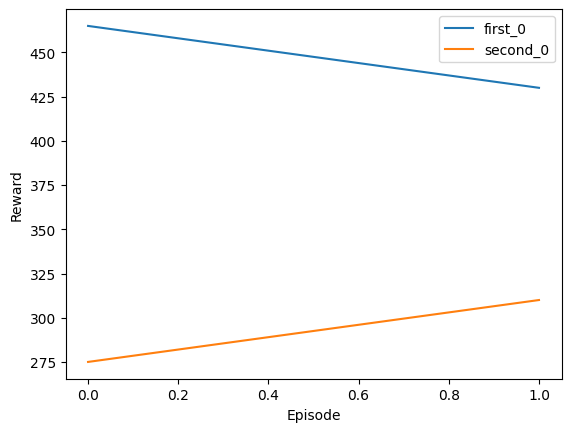

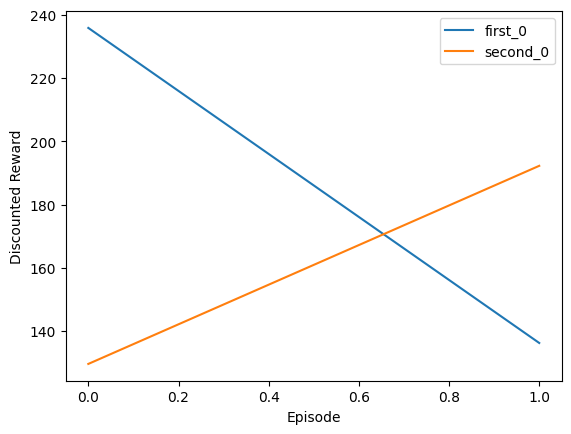

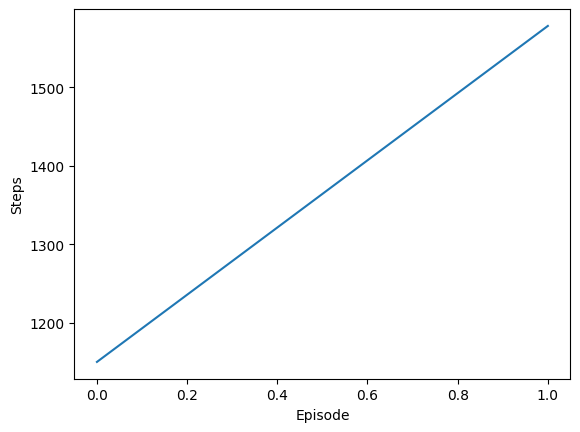

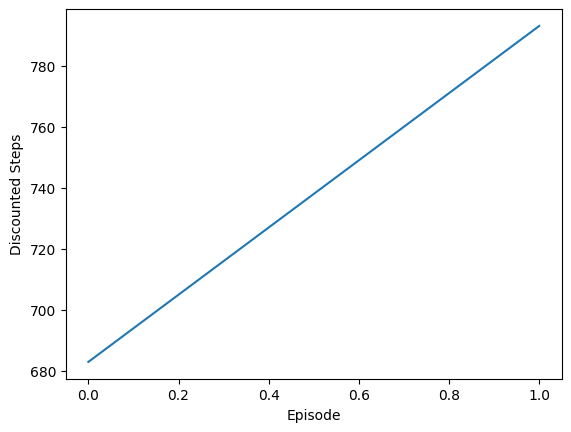

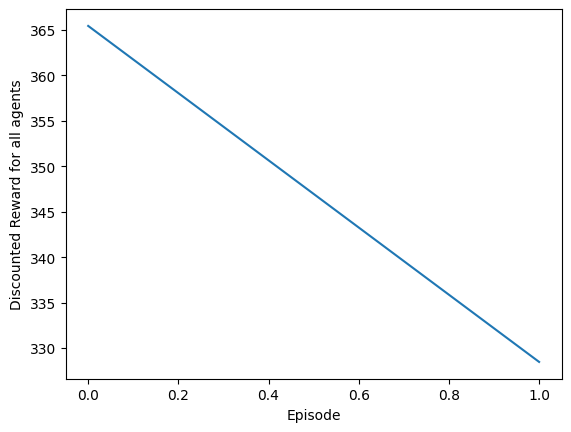

Mean rewards: {'first_0': 447.5, 'second_0': 292.5}
Variance of rewards: {'first_0': 306.25, 'second_0': 306.25}
Mean discounted rewards: {'first_0': 186.02381960014463, 'second_0': 160.9288343202453}
Variance of discounted rewards: {'first_0': 2477.26103490392, 'second_0': 979.4323573896639}
Mean steps: 1364.0
Variance of steps: 45796.0
Mean discounted steps: 737.9217342255888
Variance of discounted steps: 3031.594103630391
Mean discounted rewards for all agents: 346.95265392038993
Variance of discounted rewards for all agents: 341.37022107329847


In [11]:
# Calculate the mean and variance of the rewards for each agent over all episodes
mean_rewards = {agent: np.mean(ep_rewards[agent]) for agent in parallel_env.possible_agents}
var_rewards = {agent: np.var(ep_rewards[agent]) for agent in parallel_env.possible_agents}

# Calculate the mean and variance of the discounted rewards for each agent over all episodes
mean_rewards_d = {agent: np.mean(ep_rewards_d[agent]) for agent in parallel_env.possible_agents}
var_rewards_d = {agent: np.var(ep_rewards_d[agent]) for agent in parallel_env.possible_agents}

# Calculate the mean and variance of the steps for all agents over all episodes
mean_steps = np.mean(ep_steps)
var_steps = np.var(ep_steps)

# Calculate the mean and variance of the discounted steps for all agents over all episodes
mean_steps_d = np.mean(ep_steps_d)
var_steps_d = np.var(ep_steps_d)

# Calculate the mean and variance of the discounted rewards for all agents over all episodes
mean_rewards_d_all = np.mean(ep_rewards_d_all)
var_rewards_d_all = np.var(ep_rewards_d_all)

# Plot the the rewards curve for each agent over all episodes
plt.figure()
for agent in parallel_env.possible_agents:
    plt.plot(ep_rewards[agent], label=agent)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Plot the the discounted rewards curve for each agent over all episodes
plt.figure()
for agent in parallel_env.possible_agents:
    plt.plot(ep_rewards_d[agent], label=agent)
plt.xlabel("Episode")
plt.ylabel("Discounted Reward")
plt.legend()
plt.show()

# Plot the the steps curve for all agents over all episodes
plt.figure()
plt.plot(ep_steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

# Plot the the discounted steps curve for all agents over all episodes
plt.figure()
plt.plot(ep_steps_d)
plt.xlabel("Episode")
plt.ylabel("Discounted Steps")
plt.show()

# Plot the the discounted rewards curve for all agents over all episodes
plt.figure()
plt.plot(ep_rewards_d_all)
plt.xlabel("Episode")
plt.ylabel("Discounted Reward for all agents")
plt.show()

# Print the mean and variance of the rewards for each agent over all episodes
print("Mean rewards: {}".format(mean_rewards))
print("Variance of rewards: {}".format(var_rewards))

# Print the mean and variance of the discounted rewards for each agent over all episodes
print("Mean discounted rewards: {}".format(mean_rewards_d))
print("Variance of discounted rewards: {}".format(var_rewards_d))

# Print the mean and variance of the steps for all agents over all episodes
print("Mean steps: {}".format(mean_steps))
print("Variance of steps: {}".format(var_steps))

# Print the mean and variance of the discounted steps for all agents over all episodes
print("Mean discounted steps: {}".format(mean_steps_d))
print("Variance of discounted steps: {}".format(var_steps_d))

# Print the mean and variance of the discounted rewards for all agents over all episodes
print("Mean discounted rewards for all agents: {}".format(mean_rewards_d_all))
print("Variance of discounted rewards for all agents: {}".format(var_rewards_d_all))



## PPO agent

In [ ]:
#TODO

## MADDPG agent

In [ ]:
#TODO